In [99]:
# use ggplot eventually
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import datetime as dt
from datetime import date

PATH_TO_DATA = '../data/'
PATH_TO_OUTPUT_DATA = '../output-data/'

In [117]:
MLB_GAME_DF_FINAL = pd.read_csv(PATH_TO_OUTPUT_DATA + 'GAME_LEVEL.csv')
MLB_GAME_DF_FINAL['dt'] = MLB_GAME_DF_FINAL['dt'].apply(lambda x:
                                                        dt.datetime.strptime(str(x), '%Y-%m-%d'))

Flow:

$$ELO_{Begin} = ELO_{Base} + Covariates$$ (538 model; Covariates do not have to have simple relationships
$$Compute_{ELO}$$ 
function updates ELOs

$$E_A=\frac{1}{1+10^{-(R_A - R_B)/200}}$$

$$R_A^{t+1}=R_A+16 \cdot(S_A-E_A)$$

Goal is to tune constants so that small differences in ELO don't impact too much

In [268]:
def initialize_elo_df(year, initial_values = []):
    ELO_STARTER_DF = MLB_GAME_DF_FINAL[['dt', 'Y']] # only use Y for filtering
    elo_df = ELO_STARTER_DF[ELO_STARTER_DF.Y == year].drop_duplicates().reset_index(drop = True)
    
    # baseline
    if (len(initial_values) == 0):
        for col in sorted(list(MLB_GAME_DF_FINAL.home_team.unique())):
            elo_df[col] = None
            elo_df.loc[0, col] = 1500 # just as a baseline
    else:
        for col in sorted(list(MLB_GAME_DF_FINAL.home_team.unique())):
            elo_df[col] = None
            elo_df.loc[0, col] = initial_values[col] # just as a baseline
    return elo_df.drop(columns = ['Y']).set_index('dt') # datetime index is easy!

In [380]:
# E_A, where A is the home team (so closer to 1 = chance home team wins)
def expected_elo_outcome(dt, home, away, elo_df, EXP_CONSTANT = 200):
    '''
        note that home and away are in AWAY @ HOME order in MLB_GAME_DF_FINAL
        dt = date of the game
        takes both teams current ELOs and computes
        check runtime!
    '''
    home_elo_prior = elo_df.loc[dt, home]
    away_elo_prior = elo_df.loc[dt, away]
    elo_expectation = (1 + 10**(-(home_elo_prior - away_elo_prior)/EXP_CONSTANT))**(-1) # equation works
    # function not used with compute_ELOs
    return elo_expectation

def compute_elo(dt, home, away, outcome, elo_df, K = 16, EXP_CONSTANT = 200):
    '''
        computes our new elos
        thoughts on K...scale based on time in season?
    '''
#     print()
    home_elo_prior = elo_df.loc[dt, home]
    away_elo_prior = elo_df.loc[dt, away]
    elo_expectation = (1 + 10**(-(home_elo_prior - away_elo_prior)/EXP_CONSTANT))**(-1) # equation works
#     print(str(home_elo_prior) + ' ' + str(away_elo_prior) + ' ' + str(elo_expectation))
#     expected_outcome = expected_elo_outcome(dt, away, home, elo_df)
#     print(outcome - elo_expectation)
    elo_delta = K * (outcome - elo_expectation)
    
    # if home team wins, Sa-Ea is positive; otherwise is negative and benefits away team
    home_elo_after = home_elo_prior + elo_delta
    away_elo_after = away_elo_prior - elo_delta
#     print(str(home_elo_after) + ' ' + str(away_elo_after) + ' ' + str(outcome))
    return [home_elo_after, away_elo_after, elo_expectation]

In [381]:
def compute_season_elos(year, initial_values = []):
    '''
        naive predictor based on the higher ELO
    '''
    # initialize data
    elo_YEAR = initialize_elo_df(year, initial_values)
    total_predictions = 0
    total_correct = 1
    
    for i in range(len(elo_YEAR)):    
        current_date = elo_YEAR.index[i]
        # uncaught try
        if (i + 1 == len(elo_YEAR)):
            break
        next_date = elo_YEAR.index[i + 1]
        if (i % 81 == 0):
            print(i)
        # loop over all the matches that day
        RELEVANT_GAMES = MLB_GAME_DF_FINAL[MLB_GAME_DF_FINAL.dt == current_date].reset_index()
        for i in range(len(RELEVANT_GAMES)):
            row = RELEVANT_GAMES.iloc[i]
                
            new_elos = compute_elo(current_date, 
                                   row.home_team,
                                   row.away_team, 
                                   row.outcome, elo_YEAR)
            elo_YEAR.loc[next_date, row.home_team] = new_elos[0]
            elo_YEAR.loc[next_date, row.away_team] = new_elos[1]
            total_predictions = total_predictions + 1
            if (((new_elos[2] >= .5) & (row.outcome == 1)) | 
                ((new_elos[2] < .5) & (row.outcome == 0))):
                total_correct = total_correct + 1

            
            if (row.home_team == 'SEA'):
                print(str(current_date) + ': ' + str(new_elos[0]) + ' ' + str(row.outcome))
            if (row.away_team == 'SEA'):
                print(str(current_date) + ': '  + str(new_elos[1])  + ' ' + str(1 - row.outcome))
                
        # update remaining elos - ideally we have a better way to check this
        for col in elo_YEAR:
            if (elo_YEAR.loc[next_date, col] == None):
                elo_YEAR.loc[next_date, col] = elo_YEAR.loc[current_date, col]

    print(100 * total_correct/total_predictions) # accuracy
    return elo_YEAR

In [382]:
elo_2000_df = compute_season_elos(2000)

0
2000-04-04 00:00:00: 1492.0 0
2000-04-05 00:00:00: 1500.7347507644877 1
2000-04-06 00:00:00: 1508.6670793323042 1
2000-04-07 00:00:00: 1516.5384444145318 1
2000-04-08 00:00:00: 1507.6880438777807 0
2000-04-09 00:00:00: 1515.649570666605 1
2000-04-11 00:00:00: 1505.6631880143427 0
2000-04-12 00:00:00: 1512.561233686078 1
2000-04-13 00:00:00: 1502.84402369844 0
2000-04-14 00:00:00: 1510.0398211132983 1
2000-04-15 00:00:00: 1516.586449213786 1
2000-04-16 00:00:00: 1522.5589591941807 1
2000-04-18 00:00:00: 1513.603629879565 0
2000-04-19 00:00:00: 1505.4685493928223 0
2000-04-21 00:00:00: 1512.5614020549042 1
2000-04-22 00:00:00: 1519.0166987559107 1
2000-04-23 00:00:00: 1524.9087270708628 1
2000-04-24 00:00:00: 1516.342297777327 0
2000-04-25 00:00:00: 1524.5638597148263 1
2000-04-26 00:00:00: 1516.0290433643147 0
2000-04-28 00:00:00: 1506.5248118199397 0
2000-04-29 00:00:00: 1513.8792459923611 1
2000-04-30 00:00:00: 1504.5668713967646 0
2000-05-02 00:00:00: 1511.5981695754904 1
2000-05-0

In [385]:
init_01 = elo_2000_df.loc[max(elo_2000_df.index)]
init_01

ANA    1511.49
ARI    1495.36
ATL    1509.69
BAL    1516.48
BOS    1535.55
CHA    1519.51
CHN    1422.98
CIN     1552.9
CLE    1542.09
COL    1484.03
DET    1487.48
HOU    1508.81
KCA    1504.29
LAN    1531.09
MIA     1487.9
MIL    1512.88
MIN    1468.34
NYA    1467.79
NYN    1521.43
OAK    1560.78
PHI    1418.03
PIT    1491.27
SDN    1473.19
SEA    1526.52
SFN    1543.14
SLN    1530.93
TBA    1498.48
TEX    1460.86
TOR    1493.47
WAS    1433.21
Name: 2000-10-01 00:00:00, dtype: object

In [386]:
elo_2001_df = compute_season_elos(2001, init_01)

0
2001-04-02 00:00:00: 1536.0773916232774 1
2001-04-03 00:00:00: 1528.7729491306047 0
2001-04-04 00:00:00: 1538.1297917390098 1
2001-04-06 00:00:00: 1543.0372536871726 1
2001-04-07 00:00:00: 1547.5688735672534 1
2001-04-08 00:00:00: 1535.7693579528977 0
2001-04-10 00:00:00: 1543.7602784766602 1
2001-04-11 00:00:00: 1551.0173547930963 1
2001-04-12 00:00:00: 1557.6184097618238 1
2001-04-13 00:00:00: 1547.7170032213905 0
2001-04-14 00:00:00: 1554.6960787941186 1
2001-04-15 00:00:00: 1561.0505740500494 1
2001-04-16 00:00:00: 1566.1093170037998 1
2001-04-17 00:00:00: 1570.773996170313 1
2001-04-18 00:00:00: 1559.091820018195 0
2001-04-19 00:00:00: 1564.5929280286769 1
2001-04-20 00:00:00: 1569.6462579495774 1
2001-04-21 00:00:00: 1574.3061778158012 1
2001-04-22 00:00:00: 1578.6198068561057 1
2001-04-24 00:00:00: 1583.7815799073717 1
2001-04-25 00:00:00: 1588.5368251732557 1
2001-04-26 00:00:00: 1592.9344442057075 1
2001-04-27 00:00:00: 1596.2826695955223 1
2001-04-28 00:00:00: 1599.43135074

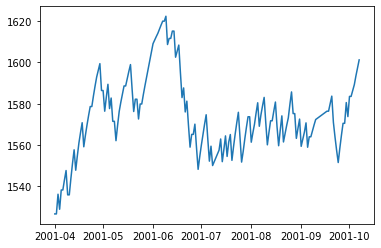

In [388]:
plt.plot(elo_2001_df.SEA)

In [1]:
elo_2001_df

NameError: name 'elo_2001_df' is not defined

In [390]:
init_02 = elo_2001_df.loc[max(elo_2001_df.index)]
elo_2002_df = compute_season_elos(2002, init_02)

0
2002-04-01 00:00:00: 1589.475376113855 0
2002-04-02 00:00:00: 1594.6030844905804 1
2002-04-03 00:00:00: 1599.3283902416756 1
2002-04-05 00:00:00: 1607.9368898810958 1
2002-04-06 00:00:00: 1599.7537269987877 0
2002-04-07 00:00:00: 1592.323264120925 0
2002-04-08 00:00:00: 1595.244857998529 1
2002-04-09 00:00:00: 1598.0092150164369 1
2002-04-10 00:00:00: 1600.6310334030948 1
2002-04-11 00:00:00: 1603.123180420681 1
2002-04-12 00:00:00: 1606.8321253403124 1
2002-04-13 00:00:00: 1610.303335411498 1
2002-04-14 00:00:00: 1613.5622088748896 1
2002-04-15 00:00:00: 1616.6306729614007 1
2002-04-16 00:00:00: 1623.2787666263844 1
2002-04-17 00:00:00: 1629.3407588657374 1
2002-04-19 00:00:00: 1615.869779970002 0
2002-04-20 00:00:00: 1619.1310647014234 1
2002-04-21 00:00:00: 1622.201695355952 1
2002-04-22 00:00:00: 1624.409376516394 1
2002-04-23 00:00:00: 1626.522085960933 1
2002-04-24 00:00:00: 1612.547175341059 0
2002-04-26 00:00:00: 1600.902238085939 0
2002-04-27 00:00:00: 1606.1567532667113 1
2

In [391]:
elo_2002_df

,ANA,ARI,ATL,BAL,BOS,CHA,CHN,CIN,CLE,COL,...,PHI,PIT,SDN,SEA,SFN,SLN,TBA,TEX,TOR,WAS
dt,,,,,,,,,,,,,,,,,,,,,
2002-03-31,1441.97,1522.44,1523.73,1448.72,1464.56,1512.43,1507.55,1471.1,1505.82,1487.58,...,1484.89,1474.09,1490.66,1601.24,1525.04,1566.81,1523.81,1490.05,1509.79,1450.59
2002-04-01,1436.79,1522.44,1523.73,1448.72,1464.56,1512.43,1507.55,1471.1,1511.01,1487.58,...,1484.89,1474.09,1490.66,1601.24,1525.04,1566.81,1523.81,1490.05,1509.79,1450.59
2002-04-02,1436.79,1528.99,1529.97,1459.68,1458.6,1524.2,1497.9,1480.75,1511.01,1482.99,...,1478.65,1468.27,1484.1,1589.48,1525.04,1571.39,1523.81,1487.05,1515.75,1450.59
2002-04-03,1448.01,1534.97,1529.97,1459.68,1458.6,1519.07,1497.9,1480.75,1499.78,1482.99,...,1478.65,1468.27,1478.13,1594.6,1532.2,1571.39,1528.54,1484.22,1515.75,1459.41
2002-04-04,1442.33,1524.44,1519.67,1453.73,1458.6,1514.34,1505.11,1473.54,1505.47,1494.74,...,1488.95,1478.93,1488.65,1599.33,1538.71,1559.64,1532.91,1481.53,1515.75,1451.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-09-25,1558.72,1503.6,1516.99,1422.99,1535.17,1527.38,1438.11,1462.96,1472.19,1516.73,...,1519.34,1476.68,1468.25,1535.18,1558.24,1568.25,1472.89,1502.2,1509.75,1514.71
2002-09-26,1548.2,1498.44,1525.1,1418.68,1526.81,1535.74,1431.25,1469.82,1466.04,1508.84,...,1511.23,1484.74,1464.06,1546.01,1562.43,1573.4,1467.22,1512.72,1514.05,1505.7
2002-09-27,1554.59,1506.92,1525.1,1414.68,1519.22,1543.32,1425,1476.08,1476.42,1500.36,...,1511.23,1484.74,1458.84,1539.94,1562.43,1576.28,1467.22,1506.33,1518.05,1513.51


In [397]:
elo_2002_df.loc[max(elo_2002_df.index)]

ANA    1554.04
ARI    1521.62
ATL    1535.73
BAL    1408.22
BOS     1514.1
CHA    1525.06
CHN    1430.72
CIN    1464.02
CLE    1488.64
COL    1485.67
DET     1399.9
HOU     1501.7
KCA    1428.71
LAN    1541.49
MIA    1494.57
MIL    1448.75
MIN     1527.2
NYA    1537.22
NYN    1459.34
OAK     1602.9
PHI    1510.43
PIT    1479.02
SDN    1449.59
SEA    1540.49
SFN     1573.5
SLN    1566.51
TBA    1472.34
TEX    1498.13
TOR    1524.79
WAS    1525.57
Name: 2002-09-29 00:00:00, dtype: object